In [1]:
import numpy as np
import intracluster_smote
import evaluation
import matplotlib.pyplot as plt
%matplotlib inline
import mnist_utils
import asirra_utils
import pandas as pd
from IPython.display import display
import seaborn as sns
import sklearn
import sklearn.cluster
import traceback
import random

# Clustering Algorithms
These algorithms are used to cluster the dataset. Their output will later serve as input to Intracluster SMOTE to generate artificial data.

In [2]:
def kmeans(X,k):
#     if X.shape[0] < 5000: # 10000 recommended
#         return sklearn.cluster.KMeans(n_clusters=k).fit(X).labels_
#     else:
    return sklearn.cluster.MiniBatchKMeans(n_clusters=k, init_size=min(2*k, X.shape[0])).fit(X).labels_

In [3]:
# Define Clustering on Autoencoder Encoding
from keras.callbacks import TensorBoard
# Fixup for keras for Tensorboard > 0.12
import tensorflow as tf
tf.merge_all_summaries = tf.summary.merge_all
tf.train.SummaryWriter = tf.summary.FileWriter
import time
import autoencoder_keras
def autoencoder_kmeans(X,k):
    ae = autoencoder_keras.Autoencoder(
        layers=[X.shape[1],128,64,min(32,X.shape[1]),64,128,X.shape[1]], 
        training_set=X
    )
    ae.fit(train, train,
            nb_epoch=1000,
            batch_size=256,
            shuffle=True,
            verbose=0,
            callbacks=[TensorBoard(log_dir=('./log/{0}'.format(time.asctime().replace(":","h",1).replace(":","m",1))))]
    )
    H = ae.encode(X)
    return (H, kmeans(H,k), ae.decode)

Using TensorFlow backend.


In [4]:
# Define Autoencoder Clustering
import autoencoder
def autoencoder_clustering(X,k): 
    # Pretrain using Keras AE
    ae = autoencoder_keras.Autoencoder(
        layers=[X.shape[1],128,64,min(32,X.shape[1]),64,128,X.shape[1]], 
        training_set=X
    )
    ae.fit(train, train,
            nb_epoch=1000,
            batch_size=256,
            shuffle=True,
            verbose=0,
            callbacks=[TensorBoard(log_dir=('./log/{0}'.format(time.asctime().replace(":","h",1).replace(":","m",1))))]
    )
    # Cluster with clustering AE
    clustering_ae = autoencoder.Autoencoder(
        layers=[X.shape[1],128,64,min(32,X.shape[1]),64,128,X.shape[1]], 
        training_set=X
    )
    clustering_ae.set_parameters(ae.get_weights())
    clustering_ae.cluster(epochs=50, eta=0.01, q=0.01, k=k, minibatch_size=256, mu=0.7)
    H = clustering_ae.encode(X)
    return (H, clustering_ae.get_cluster_assignment(X), clustering_ae.decode)

In [5]:
# each of these returns a tuple of (clustering_function(X,k), decoder)
preprocessing_methods = {
    'No Oversampling': (lambda X, k: (X, None, None)),
    'SMOTE': (lambda X, k: (X, np.zeros(X.shape[0],), None)),
    'Random Clustering': (lambda X, k: (X, np.random.choice(k, size=(X.shape[0])), None)),
    'K-Means': (lambda X, k: (X, kmeans(X,k), None)),
    'K-Means on Autoencoder Encoding': autoencoder_kmeans,
    'Autoencoder Clustering': autoencoder_clustering
}

# Datasets
Import some datasets to use to test the various data generation methods.

In [6]:
# Import Ecoli Dataset
ecoli_scaler = sklearn.preprocessing.MinMaxScaler()
def load_ecoli(ratio=None):
    ecoli_data_raw = pd.read_csv('datasets/ecoli.data.txt', delim_whitespace=True, header=None, names=['Sequence Name','mcg','gvh','lip','chg','aac','alm1','alm2','class'])
    ecoli_data_target = ecoli_data_raw['class'].as_matrix()
    ecoli_data = ecoli_data_raw.drop(['Sequence Name','class'], axis=1).as_matrix()
    ecoli_data = ecoli_scaler.fit_transform(ecoli_data)
    ecoli_train, ecoli_validate, ecoli_train_target, ecoli_validate_target = sklearn.model_selection.train_test_split(ecoli_data, ecoli_data_target)
    return (ecoli_train, ecoli_train_target), (ecoli_validate, ecoli_validate_target)

In [7]:
datasets = {
    'MNIST Imbalanced 7+8': {
        'DataRetriever': mnist_utils.load_binary_imbalanced_7_8,
        'Imbalance Ratio': 1/100,
        'Minority Class': 8,
        'Scaler': sklearn.preprocessing.MinMaxScaler().fit([[0],[255]]),
        'Plotter': mnist_utils.plot
    },
    'MNIST Imbalanced 1+7': {
        'DataRetriever': mnist_utils.load_binary_imbalanced_1_7,
        'Imbalance Ratio': 1/100,
        'Minority Class': 7,
        'Scaler': sklearn.preprocessing.MinMaxScaler().fit([[0],[255]]),
        'Plotter': mnist_utils.plot
    },
#     'Asirra Imbalanced': {
#         'DataRetriever': asirra_utils.load_data_imbalanced,
#         'Imbalance Ratio': 1/5,
#         'Minority Class': 1,
#         'Scaler': sklearn.preprocessing.MinMaxScaler().fit([[0],[255]]),
#         'Plotter': asirra_utils.plot
#     },
#     'Ecoli': {
#         'DataRetriever': load_ecoli,
#         'Imbalance Ratio': 1/5.46,
#         'Minority Class':'pp',
#         'Scaler': ecoli_scaler,
#         'Plotter': None
#     }
}
def count(d):
    return d['Data'][0][0].shape[0]
def minorityCount(d): 
    return np.count_nonzero(d['Data'][0][1]==d['Minority Class'])
def majorityCount(d):
    return count(d) - minorityCount(d)


# Classifiers
These classifiers need no parameter configuration and lend themselves to benchmarking the effectiveness of data generation methods.

In [8]:
classifiers = {
    'Logistic Regression': sklearn.linear_model.LogisticRegression(),
#     'Random Forest': sklearn.ensemble.RandomForestClassifier(),
#     'Gradient Boosting': sklearn.ensemble.GradientBoostingClassifier(),
#     'Support Vector': sklearn.svm.SVC()
}

# Bringing it all together
Loop through all the datasets and evaluate the performance of the different data balancing techniques using all above classifiers.


#####################################
Dataset: MNIST Imbalanced 1+7
Train Set Size: 4000 Minority Size: 36 Imbalance Ratio: 0.01

-------------------------------------
Preprocessing Method: K-Means
Diversity Score (based on 30% of synthetic examples) 1.44 for method K-Means
Plotting MNIST Imbalanced 1+7 synthetic samples after applying K-Means


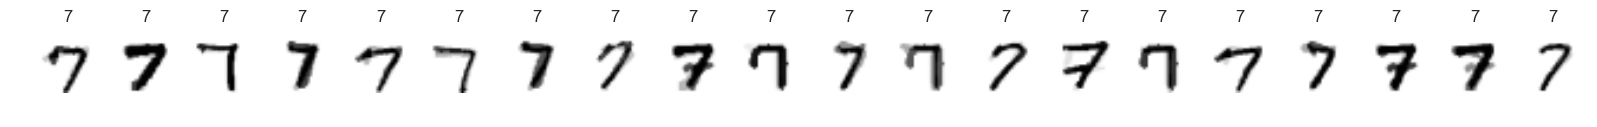

Showing examples of inputs and resulting synthetic samples for K-Means (Parent A, Offspring, Parent B)


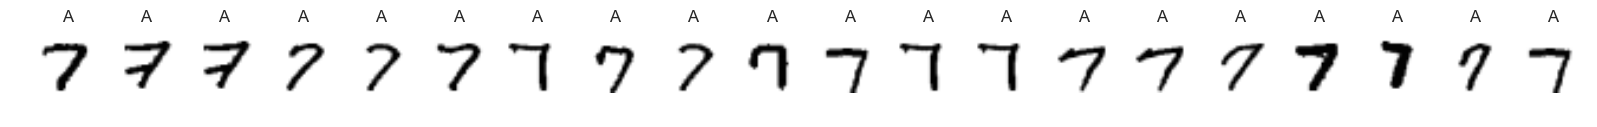

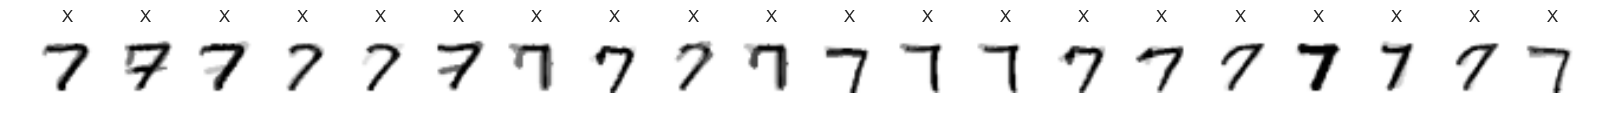

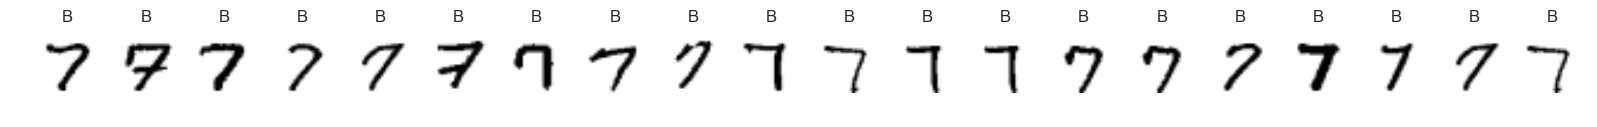


-------------------------------------
Preprocessing Method: Random Clustering
Exception occured at Random Clustering

-------------------------------------
Preprocessing Method: SMOTE


Traceback (most recent call last):
  File "<ipython-input-9-2329be2d4bee>", line 23, in <module>
    (train_oversampled, train_target_oversampled), (synth_X, synth_y)  = oversampler.fit_transform(train_encoded, train_target, dataset['Minority Class'], cluster_labels, train)
  File "C:\Users\D059331\.babun\cygwin\home\D059331\development\data\masters-thesis\autoencoder\intracluster_smote.py", line 60, in fit_transform
    generate_count = int(np.floor(self.n_intra * weight))
ValueError: cannot convert float NaN to integer
C:\Users\D059331\.babun\cygwin\home\D059331\development\data\masters-thesis\autoencoder\intracluster_smote.py:49: UserWarning: No minority clusters found. Performing regular SMOTE. Try increasing the number of clusters. Recommended number of clusters: 36 to 3964.
  warnings.warn(warning_msg)


Diversity Score (based on 30% of synthetic examples) 2.61 for method SMOTE
Plotting MNIST Imbalanced 1+7 synthetic samples after applying SMOTE


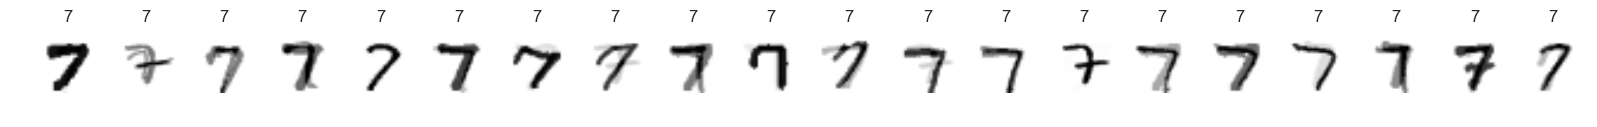

Showing examples of inputs and resulting synthetic samples for SMOTE (Parent A, Offspring, Parent B)


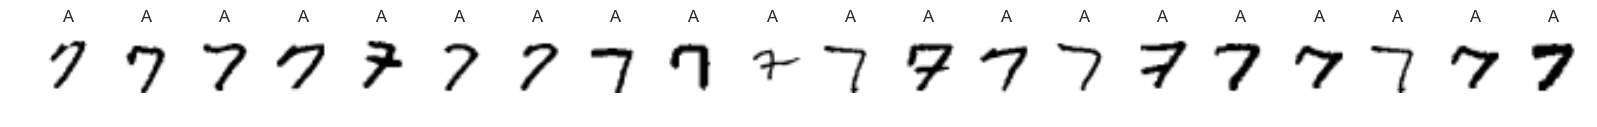

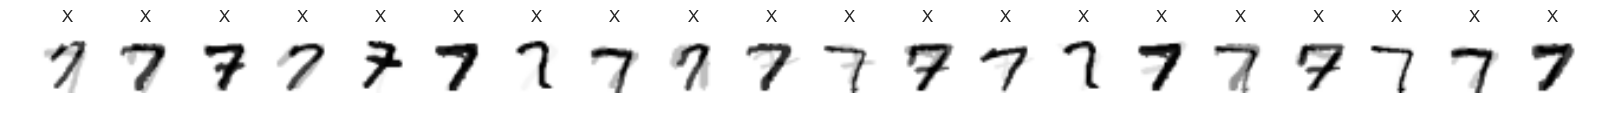

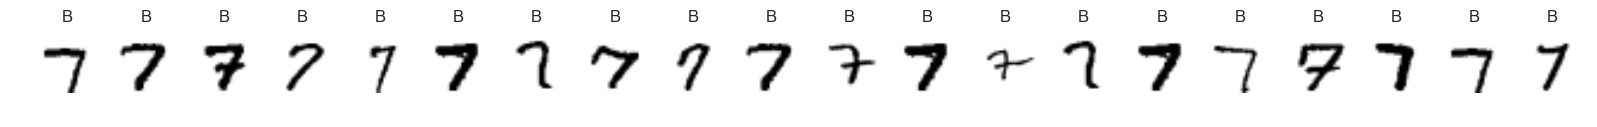


-------------------------------------
Preprocessing Method: K-Means on Autoencoder Encoding
Diversity Score (based on 30% of synthetic examples) 9.53 for method K-Means on Autoencoder Encoding
Reconstruction Quality Sample of K-Means on Autoencoder Encoding


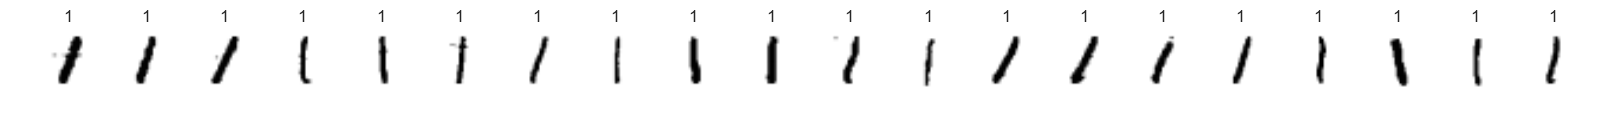

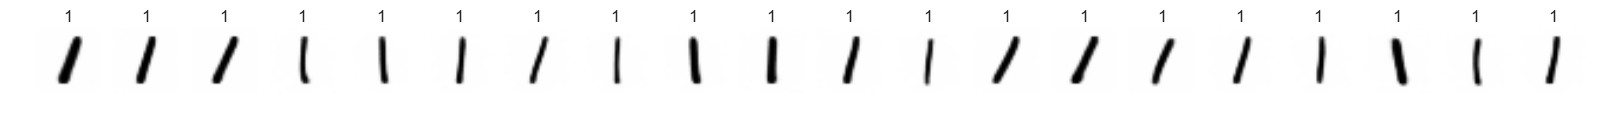

Plotting MNIST Imbalanced 1+7 synthetic samples after applying K-Means on Autoencoder Encoding


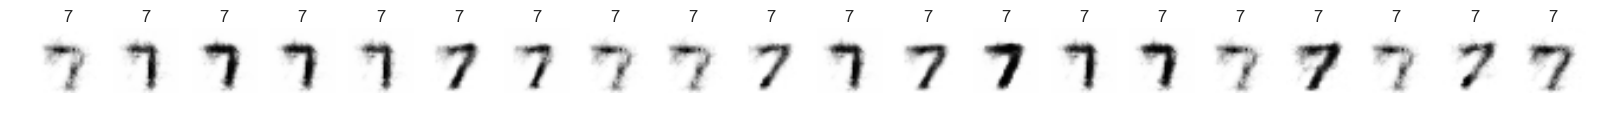

Showing examples of inputs and resulting synthetic samples for K-Means on Autoencoder Encoding (Parent A, Offspring, Parent B)


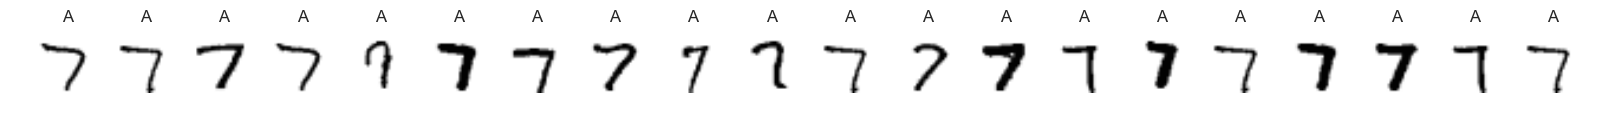

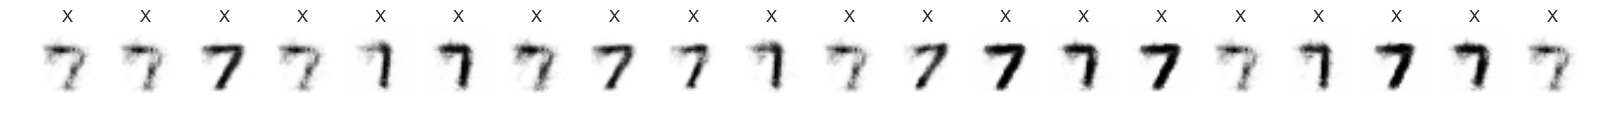

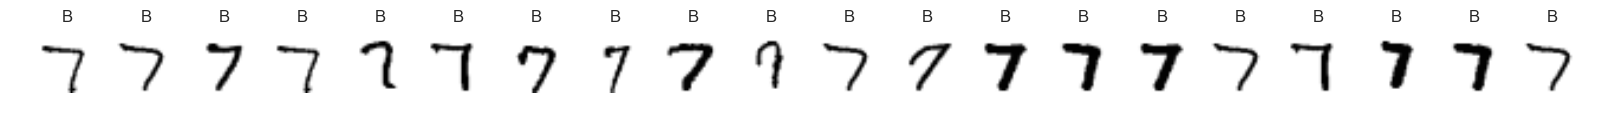


-------------------------------------
Preprocessing Method: No Oversampling

-------------------------------------
Preprocessing Method: Autoencoder Clustering
Starting training with initial training cost: 0.12889519281227257 and validation cost: 0.12889519281227257
Training Time: 462.16551542282104 Per Epoch ~ 9.24331030845642
Diversity Score (based on 30% of synthetic examples) 33.17 for method Autoencoder Clustering
Reconstruction Quality Sample of Autoencoder Clustering


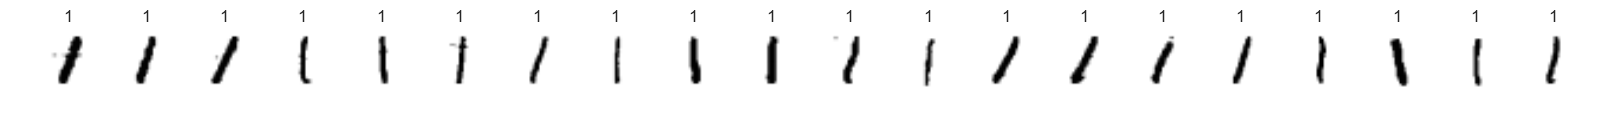

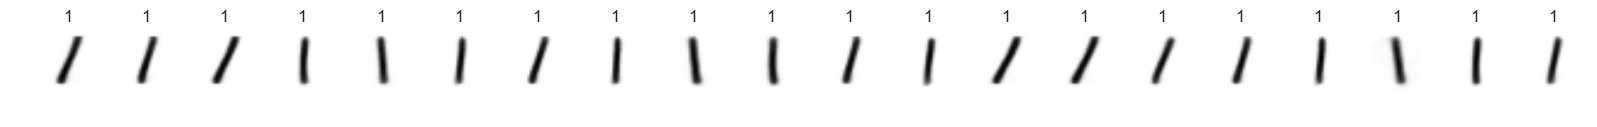

Plotting MNIST Imbalanced 1+7 synthetic samples after applying Autoencoder Clustering


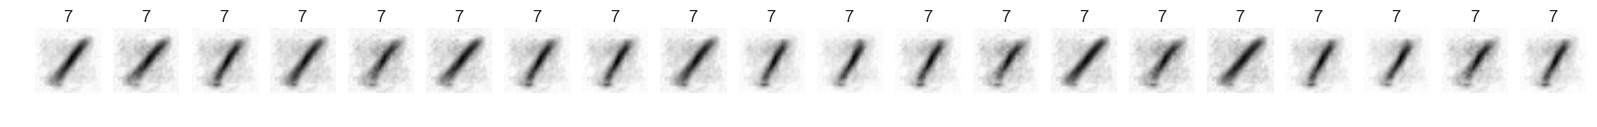

Showing examples of inputs and resulting synthetic samples for Autoencoder Clustering (Parent A, Offspring, Parent B)


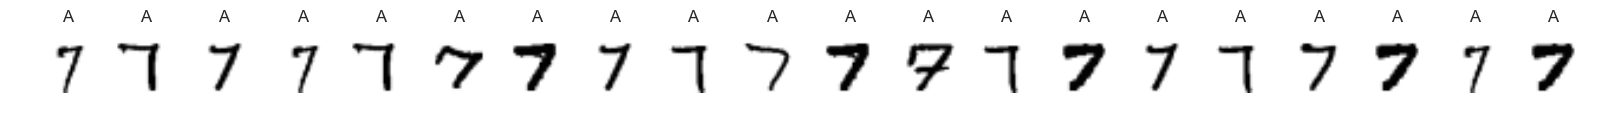

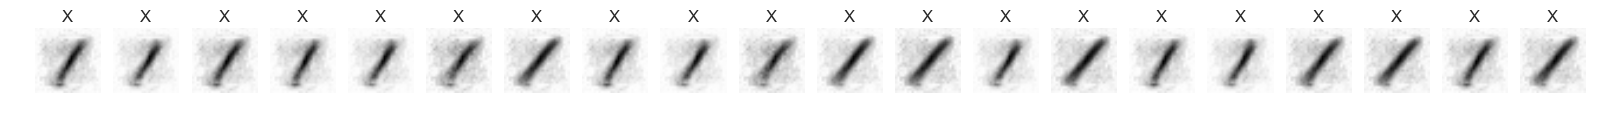

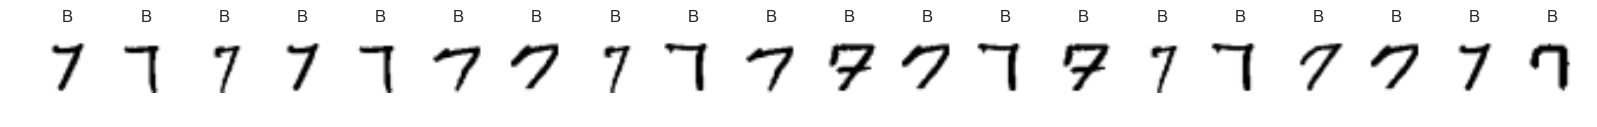


#####################################
Dataset: MNIST Imbalanced 7+8
Train Set Size: 4000 Minority Size: 40 Imbalance Ratio: 0.01

-------------------------------------
Preprocessing Method: K-Means
Diversity Score (based on 30% of synthetic examples) 1.56 for method K-Means
Plotting MNIST Imbalanced 7+8 synthetic samples after applying K-Means


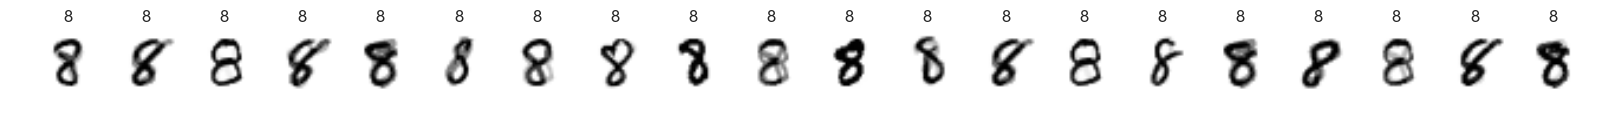

Showing examples of inputs and resulting synthetic samples for K-Means (Parent A, Offspring, Parent B)


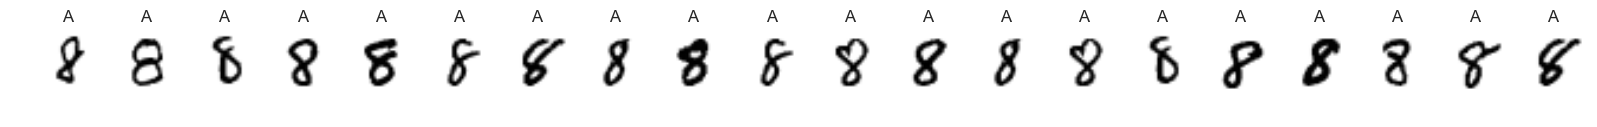

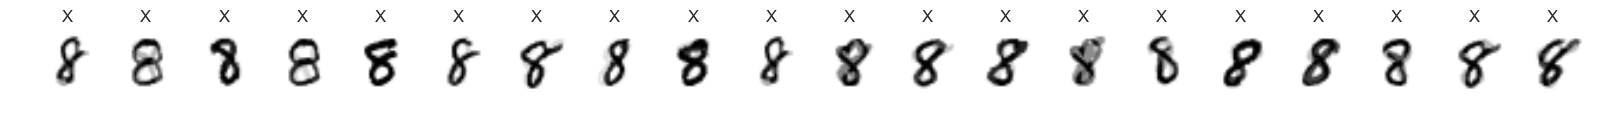

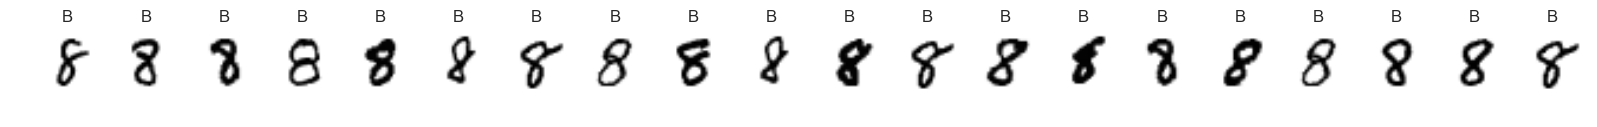


-------------------------------------
Preprocessing Method: Random Clustering
Exception occured at Random Clustering

-------------------------------------
Preprocessing Method: SMOTE


Traceback (most recent call last):
  File "<ipython-input-9-2329be2d4bee>", line 23, in <module>
    (train_oversampled, train_target_oversampled), (synth_X, synth_y)  = oversampler.fit_transform(train_encoded, train_target, dataset['Minority Class'], cluster_labels, train)
  File "C:\Users\D059331\.babun\cygwin\home\D059331\development\data\masters-thesis\autoencoder\intracluster_smote.py", line 60, in fit_transform
    generate_count = int(np.floor(self.n_intra * weight))
ValueError: cannot convert float NaN to integer
C:\Users\D059331\.babun\cygwin\home\D059331\development\data\masters-thesis\autoencoder\intracluster_smote.py:49: UserWarning: No minority clusters found. Performing regular SMOTE. Try increasing the number of clusters. Recommended number of clusters: 40 to 3960.
  warnings.warn(warning_msg)


Diversity Score (based on 30% of synthetic examples) 2.58 for method SMOTE
Plotting MNIST Imbalanced 7+8 synthetic samples after applying SMOTE


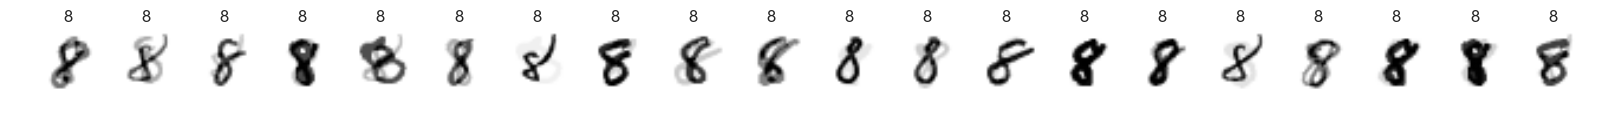

Showing examples of inputs and resulting synthetic samples for SMOTE (Parent A, Offspring, Parent B)


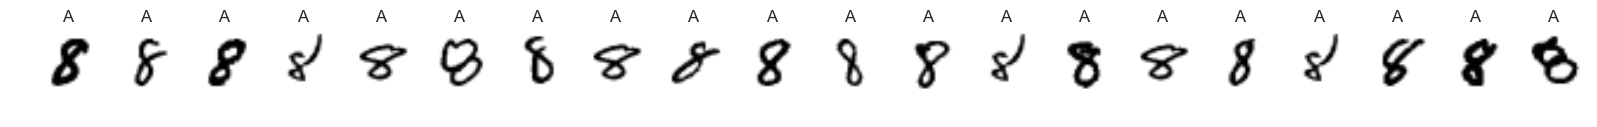

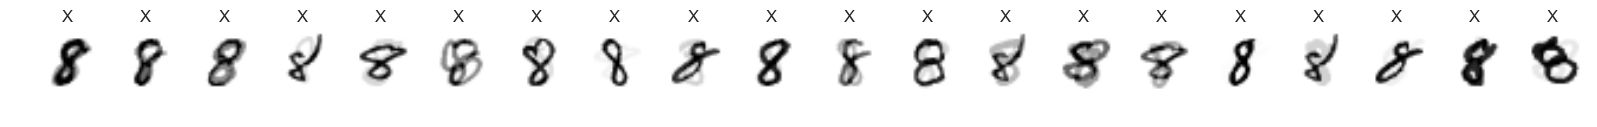

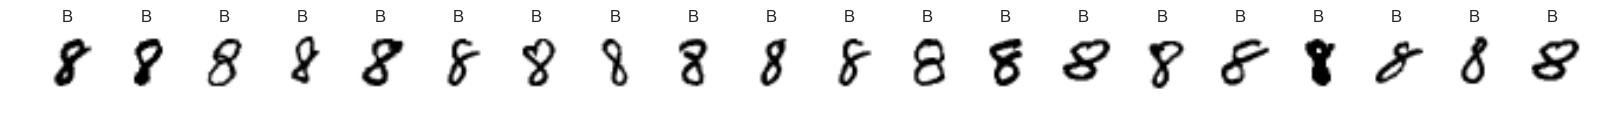


-------------------------------------
Preprocessing Method: K-Means on Autoencoder Encoding
Diversity Score (based on 30% of synthetic examples) 9.78 for method K-Means on Autoencoder Encoding
Reconstruction Quality Sample of K-Means on Autoencoder Encoding


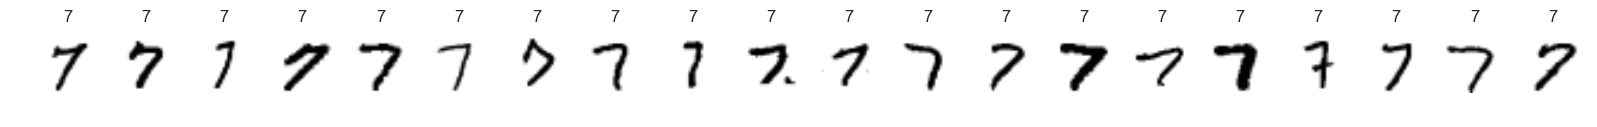

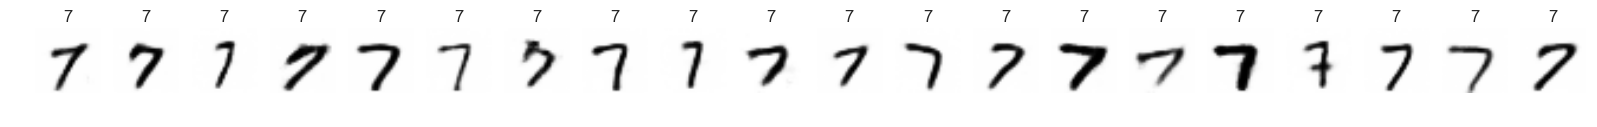

Plotting MNIST Imbalanced 7+8 synthetic samples after applying K-Means on Autoencoder Encoding


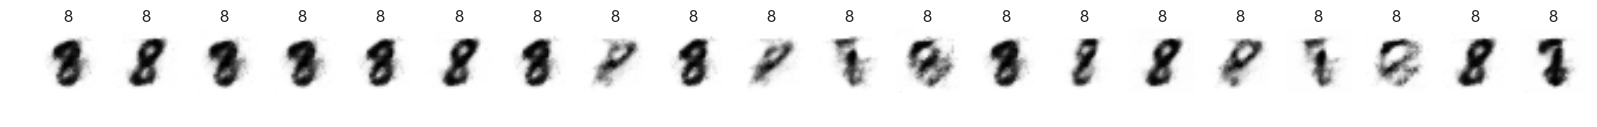

Showing examples of inputs and resulting synthetic samples for K-Means on Autoencoder Encoding (Parent A, Offspring, Parent B)


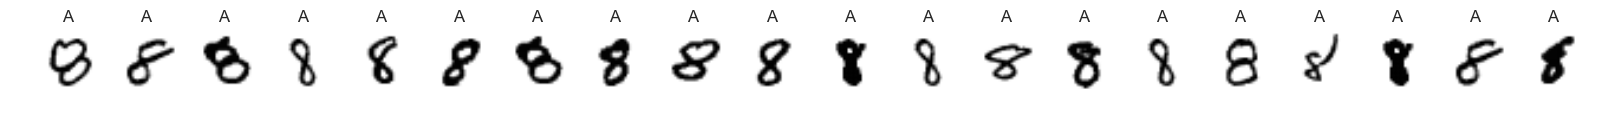

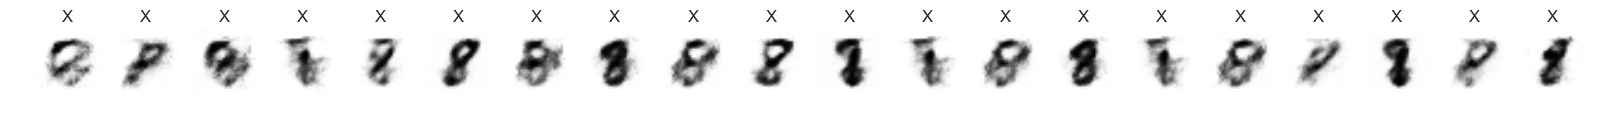

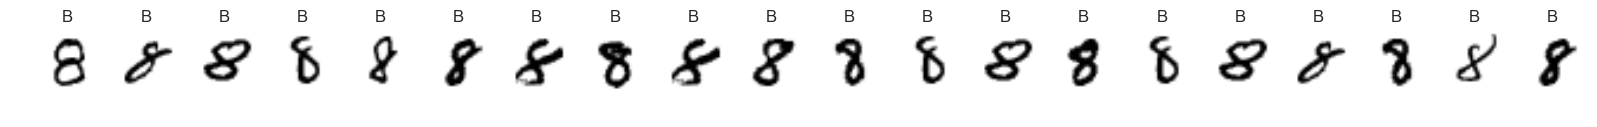


-------------------------------------
Preprocessing Method: No Oversampling

-------------------------------------
Preprocessing Method: Autoencoder Clustering
Starting training with initial training cost: 0.4245905603390656 and validation cost: 0.4245905603390656
Training Time: 455.0472686290741 Per Epoch ~ 9.100945372581482
Diversity Score (based on 30% of synthetic examples) 15.23 for method Autoencoder Clustering
Reconstruction Quality Sample of Autoencoder Clustering


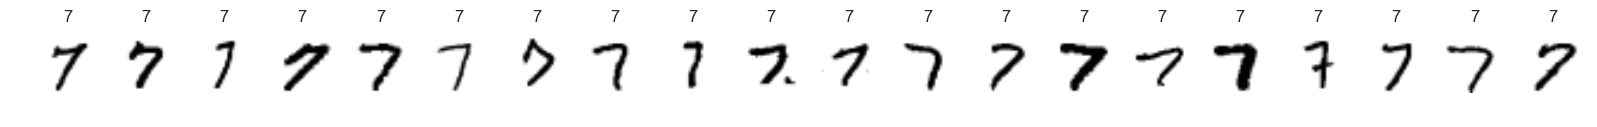

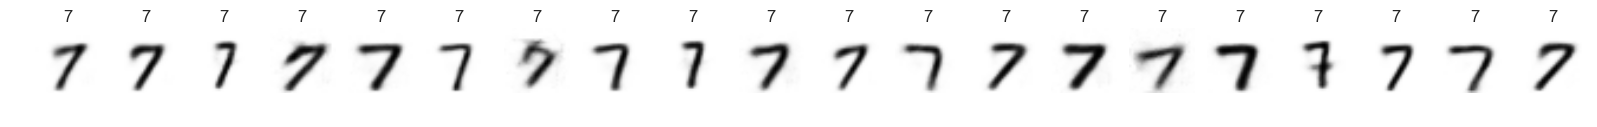

Plotting MNIST Imbalanced 7+8 synthetic samples after applying Autoencoder Clustering


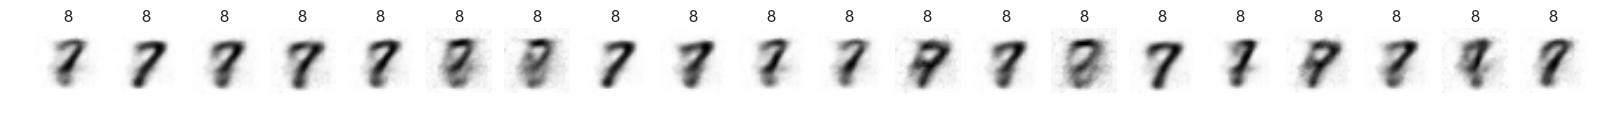

Showing examples of inputs and resulting synthetic samples for Autoencoder Clustering (Parent A, Offspring, Parent B)


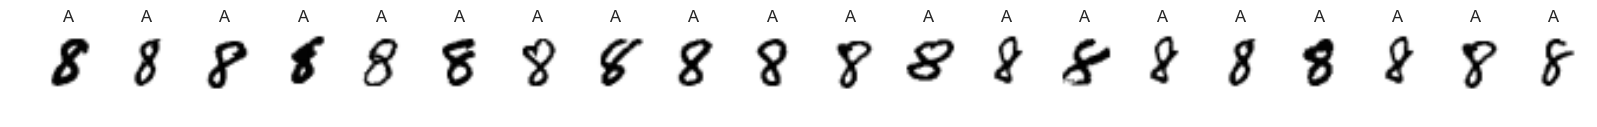

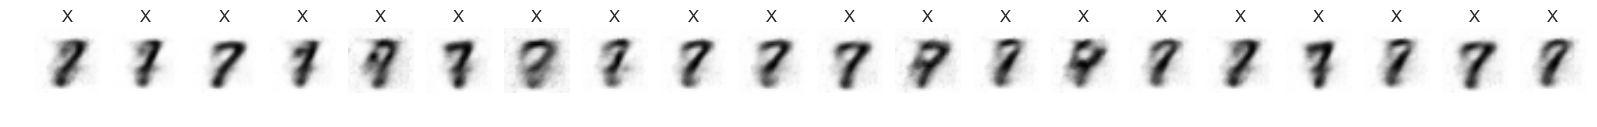

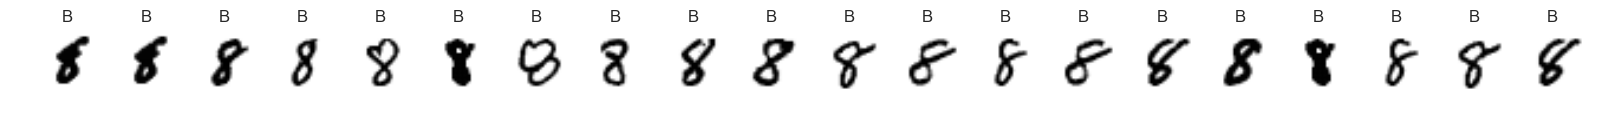

Balanced F-Measure  \
Dataset              Oversampling                    Classifier                                
MNIST Imbalanced 1+7 Autoencoder Clustering          Logistic Regression            0.778279   
                     K-Means                         Logistic Regression            0.975970   
                     K-Means on Autoencoder Encoding Logistic Regression            1.000000   
                     No Oversampling                 Logistic Regression            0.949560   
                     SMOTE                           Logistic Regression            1.000000   
MNIST Imbalanced 7+8 Autoencoder Clustering          Logistic Regression            0.656746   
                     K-Means                         Logistic Regression            0.949514   
                     K-Means on Autoencoder Encoding Logistic Regression            0.975947   
                     No Oversampling                 Logistic Regression            0.943959   
                     SMOTE                           Logistic Regression            0.954059   

                                                                          G-Measure  \
Dataset              Oversampling                    Classifier                       
MNIST Imbalanced 1+7 Autoencoder Clustering          Logistic Regression   0.831392   
                     K-Means                         Logistic Regression   0.976793   
                     K-Means on Autoencoder Encoding Logistic Regression   1.000000   
                     No Oversampling                 Logistic Regression   0.953043   
                     SMOTE                           Logistic Regression   1.000000   
MNIST Imbalanced 7+8 Autoencoder Clustering          Logistic Regression   0.767025   
                     K-Means                         Logistic Regression   0.949514   
                     K-Means on Autoencoder Encoding Logistic Regression   0.976771   
                     No Oversampling                 Logistic Regression   0.948223   
                     SMOTE                           Logistic Regression   0.956961   

                                                                          Majority Accuracy  \
Dataset              Oversampling                    Classifier                               
MNIST Imbalanced 1+7 Autoencoder Clustering          Logistic Regression           0.985022   
                     K-Means                         Logistic Regression           1.000000   
                     K-Means on Autoencoder Encoding Logistic Regression           1.000000   
                     No Oversampling                 Logistic Regression           1.000000   
                     SMOTE                           Logistic Regression           1.000000   
MNIST Imbalanced 7+8 Autoencoder Clustering          Logistic Regression           0.961089   
                     K-Means                         Logistic Regression           0.999027   
                     K-Means on Autoencoder Encoding Logistic Regression           0.999027   
                     No Oversampling                 Logistic Regression           1.000000   
                     SMOTE                           Logistic Regression           0.998054   

                                                                          Minority Accuracy  \
Dataset              Oversampling                    Classifier                               
MNIST Imbalanced 1+7 Autoencoder Clustering          Logistic Regression           1.000000   
                     K-Means                         Logistic Regression           0.909091   
                     K-Means on Autoencoder Encoding Logistic Regression           1.000000   
                     No Oversampling                 Logistic Regression           0.818182   
                     SMOTE                           Logistic Regression           1.000000   
MNIST Imbalanced 7+8 Autoencoder Clustering          Logistic Regressi

In [9]:
classification_evaulation = {}
for dataset_name, dataset in datasets.items():
    print('\n#####################################')
    print('Dataset:',dataset_name)
    if dataset_name == 'Asirra Imbalanced':continue
    dataset['Data'] = dataset['DataRetriever'](ratio=dataset['Imbalance Ratio'])
    (train, train_target), (test, test_target) = dataset['Data']
    print('Train Set Size:', count(dataset), 'Minority Size:', minorityCount(dataset), 'Imbalance Ratio:', dataset['Imbalance Ratio'])
    for preprocessing_method_name, preprocessing_method in preprocessing_methods.items():        
        print('\n-------------------------------------')
        print('Preprocessing Method:',preprocessing_method_name)
#         if preprocessing_method_name.rfind('Autoencoder') > -1: continue
        try:
            if preprocessing_method_name == 'No Oversampling':
                (train_oversampled, train_target_oversampled) = train, train_target
            else:
                #oversample
                k = minorityCount(dataset) + ((majorityCount(dataset)-minorityCount(dataset))//3)
                train_encoded, cluster_labels, decoder = preprocessing_method(train, k)
                required_synthetic_count =  intracluster_smote.compute_synthetic_count(train.shape[0], dataset['Imbalance Ratio'])
                save_creation_examples = 0.3#(30/count(dataset)) #if dataset['Plotter'] is not None else 0
                oversampler = intracluster_smote.IntraclusterSmote(required_synthetic_count, decoder=decoder, save_creation_examples=save_creation_examples)
                (train_oversampled, train_target_oversampled), (synth_X, synth_y)  = oversampler.fit_transform(train_encoded, train_target, dataset['Minority Class'], cluster_labels, train)
                print('Diversity Score (based on 30% of synthetic examples)', round(evaluation.diversion_score(train, oversampler.creation_examples), 2), 'for method', preprocessing_method_name)
                if dataset['Plotter'] is not None:
                    plot = dataset['Plotter']
                    
                    if preprocessing_method_name.rfind('Autoencoder') > -1:
                        print('Reconstruction Quality Sample of', preprocessing_method_name)
                        plot(train, train_target, 20)
                        plot(decoder(train_encoded), train_target, 20)
                        
                    print('Plotting', dataset_name, 'synthetic samples after applying', preprocessing_method_name)
                    plot(synth_X, synth_y, 20)
                    
                    print('Showing examples of inputs and resulting synthetic samples for', preprocessing_method_name, '(Parent A, Offspring, Parent B)')
                    parent_a, offspring, parent_b = zip(*random.sample(oversampler.creation_examples, len(oversampler.creation_examples))) # shuffle before to make the plot more diverse
                    for name, examples in [('A',parent_a), ('X', offspring), ('B', parent_b)]:
                        examples = np.asarray(examples)
                        plot(examples, [name for _ in examples], 20)
                    # Remove unused data to let the garbage collector work
                    del synth_X, synth_y, train_encoded, cluster_labels, decoder, oversampler
                        
            for classifier_name, classifier in classifiers.items():
                # classify
                classifier.fit(train_oversampled,train_target_oversampled)
                prediction = classifier.predict(test)
                #evaluate
                classification_evaulation[(dataset_name,preprocessing_method_name,classifier_name)] = evaluation.evaluate_classification(test_target, prediction, dataset['Minority Class'])
            # Remove unused data to let the garbage collector work
            del train_oversampled, train_target_oversampled
        except Exception as e:
            print('Exception occured at', preprocessing_method_name)
            traceback.print_exc()
    # Remove unused data to let the garbage collector work
    del dataset['Data'], train, train_target, test, test_target

res = pd.DataFrame(classification_evaulation).transpose()
res.index.names = (['Dataset', 'Oversampling', 'Classifier'])
res.to_csv('results/{0}.csv'.format(time.asctime().replace(":","h",1).replace(":","m",1)))
display(res)

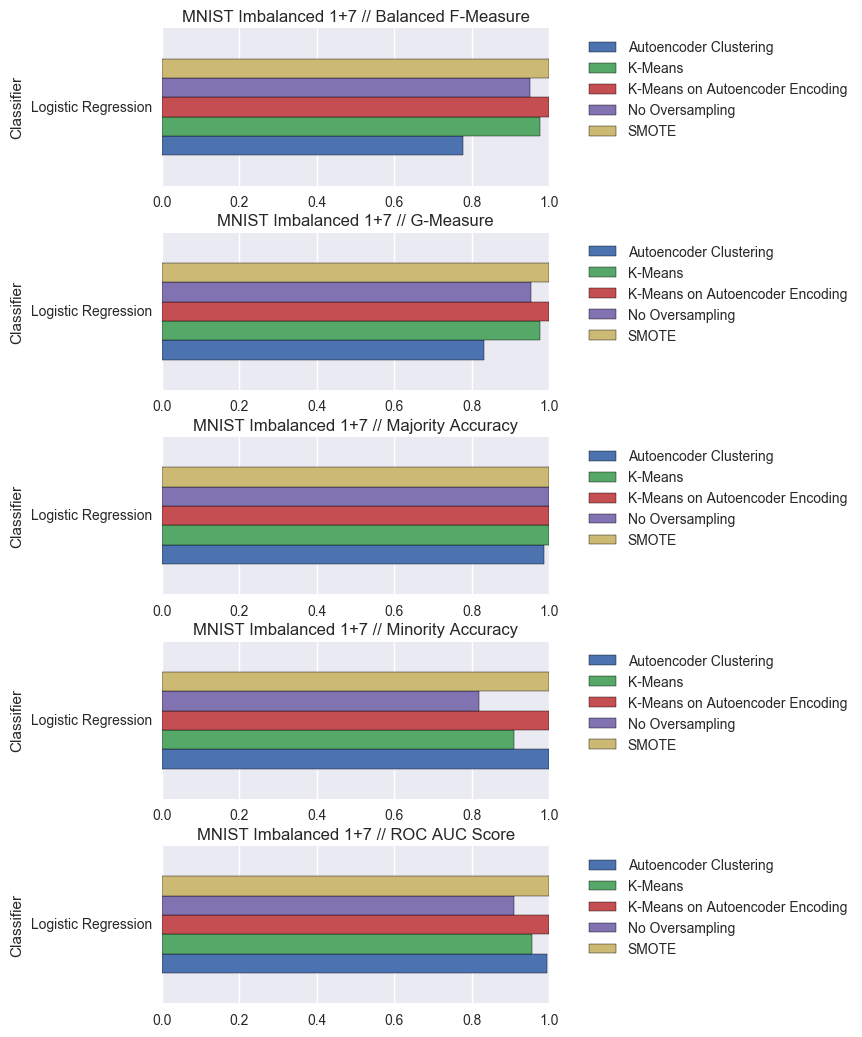

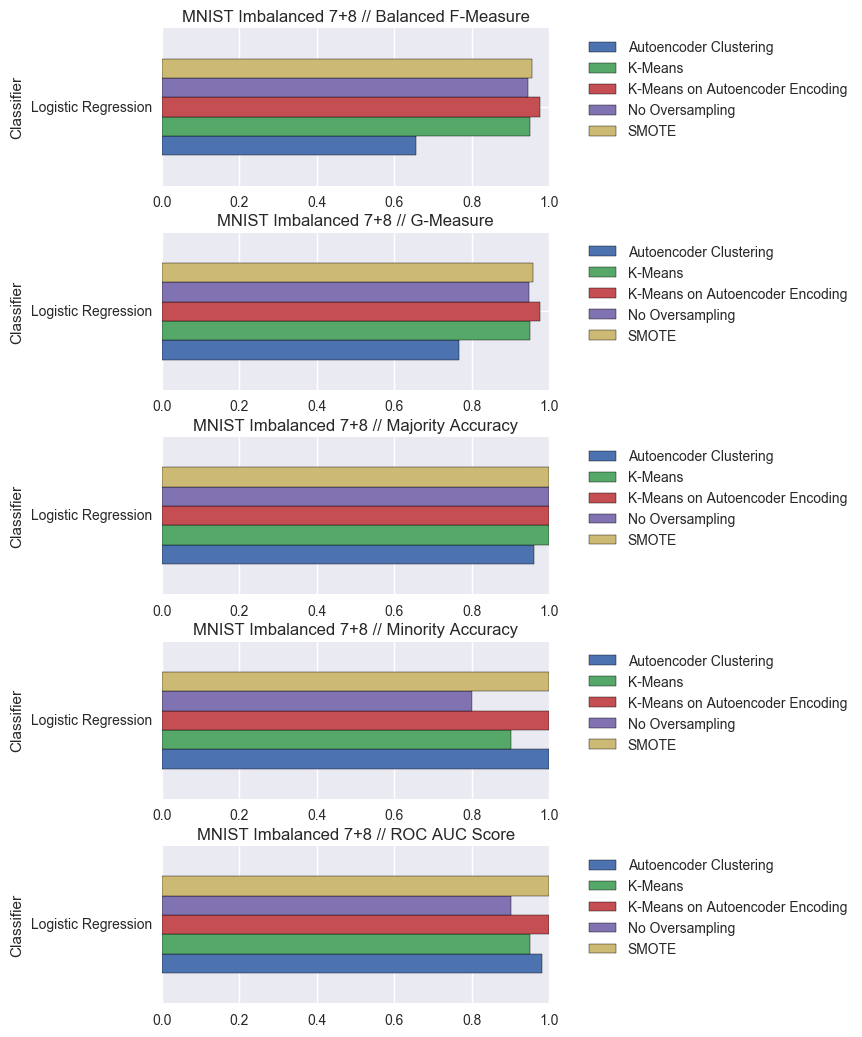

In [10]:
for dataset in res.index.levels[0].values:
    fig, axes = plt.subplots(nrows=len(res.columns), ncols=1)#, subplot_kw={'hspace':2})
    fig.subplots_adjust(top=5, hspace=0.3)
    for i, score in enumerate(res.columns):
        ax=axes[i]
        ax.set_title(dataset + ' // ' + score)
        unstacked_res = res[score][dataset].unstack(level=0)
        unstacked_res.plot(kind='barh',ax=ax, figsize=(5,2), width=.8)
        ax.legend(bbox_to_anchor=(1.8, 1))